In [1]:
from scipy.constants import electron_volt
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

import shutil
import tempfile
import subprocess
import sys
import os
import re


In [2]:
os.chdir("C:/Users/river/Documents/VSC/NOMLAB/freepaths")
sys.path.insert(0, os.path.abspath(".."))
print(sys.path[:5])
print("CWD:", os.getcwd())

['C:\\Users\\river\\Documents\\VSC\\NOMLAB', 'c:\\Users\\river\\AppData\\Local\\Programs\\Python\\Python313\\python313.zip', 'c:\\Users\\river\\AppData\\Local\\Programs\\Python\\Python313\\DLLs', 'c:\\Users\\river\\AppData\\Local\\Programs\\Python\\Python313\\Lib', 'c:\\Users\\river\\AppData\\Local\\Programs\\Python\\Python313']
CWD: C:\Users\river\Documents\VSC\NOMLAB\freepaths


In [3]:
def modify_config_run(base_cfg_path, updates): 
    # 1) Chemin vers votre config d'origine
    orig_cfg = base_cfg_path

    # 2) Création d'un fichier temporaire (garde l'extension .py pour freepaths)
    fd, tmp_path = tempfile.mkstemp(suffix=".py", prefix="config_copy_")
    os.close(fd)  # on ne l'utilise pas directement

    # Copier le contenu initial
    shutil.copy(orig_cfg, tmp_path)
    print(f"Config copiée dans {tmp_path!r}")

    # 4) Lecture + patch
    with open(tmp_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        for var, new_val in updates.items():
            # On cherche les assignations exactes en début de ligne
            pat = re.compile(rf"^(\s*{re.escape(var)}\s*=\s*).*$")
            if pat.match(line):
                # remplace par le groupe 1 suivi de la nouvelle valeur
                line = pat.sub(lambda m: m.group(1) + repr(new_val), line)
        new_lines.append(line)

    with open(tmp_path, "w", encoding="utf-8") as f:
        f.writelines(new_lines)

    print("Variables mises à jour:", updates)

    # 5) Exécuter le subprocess sur la config modifiée
    try:
        subprocess.run(
            [sys.executable, "-u", "-m", "freepaths", tmp_path, "-e"],
            check=True,                # lèvera CalledProcessError si exit != 0
            capture_output=True,       # capture stdout/stderr
            text=True                  # retourne des str au lieu de bytes
        )
    except subprocess.CalledProcessError as e:
        # si erreur :
        print(f"Processus terminé avec le code {e.returncode}")
        print("=== STDOUT ===\n", e.stdout)
        print("=== STDERR ===\n", e.stderr)
    finally:
        # 6) Nettoyage : suppression du fichier temporaire
        os.remove(tmp_path)
        print(f"Fichier temporaire {tmp_path!r} supprimé")

In [4]:
def interpolate_property(energy_levels: np.ndarray,
                         property_values: np.ndarray,
                         fermi_level: float) -> float:
    """
    Interpolate the material property at a given Fermi level.
    """
    return np.interp(fermi_level, energy_levels, property_values)

In [5]:
def extract_conductivity(output_folder_name, fermi_level):
    fermi_levels, conductivity = np.genfromtxt(f"Results/{output_folder_name}/Data/Electron conductivity.csv", unpack=True, delimiter=',', skip_header=1, usecols=(0,1),encoding='utf-8')
    return interpolate_property(fermi_levels, conductivity, fermi_level)

In [6]:
base_config = "examples/membrane_with_circular_holes.py"
necks = np.linspace(5, 40, 10) * 1e-9
conductivities = []


for neck_size in tqdm(necks, desc="Simulation neck sizes"):
    updates = { 
        "neck": neck_size,
        "OUTPUT_FOLDER_NAME": "Extract test",
        "MEDIA_FERMI_LEVEL": 0.010*electron_volt,
        }
    modify_config_run(base_config, updates)
    conductivities.append(
        extract_conductivity("Extract test", 0.010*electron_volt)
        )

Simulation neck sizes:   0%|          | 0/10 [00:00<?, ?it/s]

Config copiée dans 'C:\\Users\\river\\AppData\\Local\\Temp\\config_copy_bjqmfje_.py'
Variables mises à jour: {'neck': np.float64(5e-09), 'OUTPUT_FOLDER_NAME': 'Extract test', 'MEDIA_FERMI_LEVEL': 1.6021766339999998e-21}
Fichier temporaire 'C:\\Users\\river\\AppData\\Local\\Temp\\config_copy_bjqmfje_.py' supprimé
Config copiée dans 'C:\\Users\\river\\AppData\\Local\\Temp\\config_copy_qsbvfnq4.py'
Variables mises à jour: {'neck': np.float64(8.88888888888889e-09), 'OUTPUT_FOLDER_NAME': 'Extract test', 'MEDIA_FERMI_LEVEL': 1.6021766339999998e-21}
Fichier temporaire 'C:\\Users\\river\\AppData\\Local\\Temp\\config_copy_qsbvfnq4.py' supprimé
Config copiée dans 'C:\\Users\\river\\AppData\\Local\\Temp\\config_copy_cq3dgzfl.py'
Variables mises à jour: {'neck': np.float64(1.2777777777777779e-08), 'OUTPUT_FOLDER_NAME': 'Extract test', 'MEDIA_FERMI_LEVEL': 1.6021766339999998e-21}
Fichier temporaire 'C:\\Users\\river\\AppData\\Local\\Temp\\config_copy_cq3dgzfl.py' supprimé
Config copiée dans 'C:\\Us

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(np.array(necks)*1e9, np.array(conductivities) / conductivities[-1], s=50, alpha=0.8, edgecolor='k')
plt.title("Conductivity vs Neck size", fontsize=14)
plt.xlabel("Neck size (nm)", fontsize=12)
plt.ylabel("Conductivity ratio", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
# plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

NameError: name 'necks' is not defined

<Figure size 800x600 with 0 Axes>

In [8]:
def save_conductivities(output_folder_name):
    np.savetxt(f"Results/{output_folder_name}/neck_conductivity.csv", np.column_stack((necks, conductivities)), fmt='%2.4e', header="Neck size [m], Conductivity [S/m]", encoding='utf-8', delimiter=',')

In [9]:
save_conductivities("Extract test")

In [6]:
necks_037, cond_037 = np.genfromtxt("Results/low thickness circular hole _0.037/neck_conductivity.csv",
        unpack=True,
        delimiter=',',
        usecols=(0, 1),
        skip_header=1)
necks_012, cond_012 = np.genfromtxt("Results/low thickness circular hole 0.012/neck_conductivity.csv",
        unpack=True,
        delimiter=',',
        usecols=(0, 1),
        skip_header=1
    )
necks_100, cond_100 = np.genfromtxt("Results/low thickness circular hole _0.100/neck_conductivity.csv",
        unpack=True,
        delimiter=',',
        usecols=(0, 1),
        skip_header=1
    )
necks_m10, cond_m10 = np.genfromtxt("Results/high thickness circular hole m10/neck_conductivity.csv",
        unpack=True,
        delimiter=',',
        usecols=(0, 1),
        skip_header=1
    )
necks_m20, cond_m20 = np.genfromtxt("Results/high thickness circular hole m20/neck_conductivity.csv",
        unpack=True,
        delimiter=',',
        usecols=(0, 1),
        skip_header=1
    )
necks_m15, cond_m15 = np.genfromtxt("Results/high thickness circular hole m15/neck_conductivity.csv",
        unpack=True,
        delimiter=',',
        usecols=(0, 1),
        skip_header=1
    )
necks_m05, cond_m05 = np.genfromtxt("Results/high thickness circular hole m05/neck_conductivity.csv",
        unpack=True,
        delimiter=',',
        usecols=(0, 1),
        skip_header=1
    )

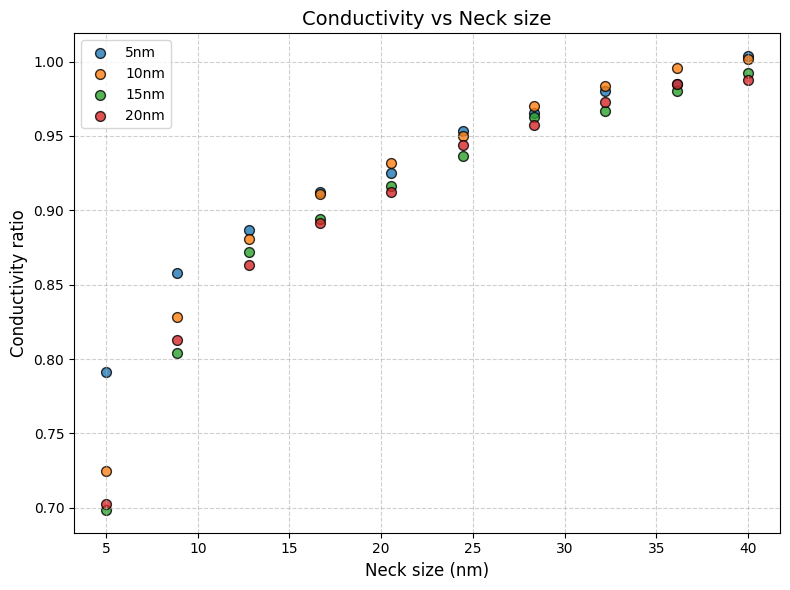

In [12]:
plt.figure(figsize=(8, 6))


plt.scatter(np.array(necks_m05)*1e9, np.array(cond_m05) / 4.1272e5, s=50, alpha=0.8, edgecolors='k', label='5nm') # valeur base
# plt.scatter(np.array(necks_m05)*1e9, np.array(cond_m05) / 7.1e5, s=50, alpha=0.8, edgecolors='k', label='5nm') # pas avec sa constante
# plt.scatter(np.array(necks_m05)*1e9, np.array(cond_m05) / 1.7e5, s=50, alpha=0.8, edgecolors='k', label='5nm')
plt.scatter(np.array(necks_m10)*1e9, np.array(cond_m10) / 4.8584e5, s=50, alpha=0.8, edgecolor='k', label="10nm") # Valeur base
# plt.scatter(np.array(necks_m10)*1e9, np.array(cond_m10) / 5.958e5, s=50, alpha=0.8, edgecolor='k', label='10nm')
plt.scatter(np.array(necks_m15)*1e9, np.array(cond_m15) / 5.4207e5, s=50, alpha=0.8, edgecolor='k', label='15nm')
plt.scatter(np.array(necks_m20)*1e9, np.array(cond_m20) / 5.0192e5, s=50, alpha=0.8, edgecolor='k', label='20nm')

plt.legend()

# plt.scatter(np.array(necks_m10)*1e9, np.array(cond_m10) / cond_m10[-1], s=50, alpha=0.8, edgecolor='k')
# plt.scatter(np.array(necks_m20)*1e9, np.array(cond_m20) / cond_m20[-1], s=50, alpha=0.8, edgecolor='k')
# plt.scatter(np.array(necks_m15)*1e9, np.array(cond_m15) / cond_m15[-1], s=50, alpha=0.8, edgecolor='k')
# plt.scatter(np.array(necks_m05)*1e9, np.array(cond_m05) / cond_m05[-1], s=50, alpha=0.8, edgecolors='k')


plt.title("Conductivity vs Neck size", fontsize=14)
plt.xlabel("Neck size (nm)", fontsize=12)
plt.ylabel("Conductivity ratio", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
# plt.ylim(bottom=0)
plt.tight_layout()
plt.show()